# Two Sigma Connect: Rental Listing Inquiries
## How much interest will a new rental listing on RentHop receive?

##### DATS6202
##### Mikko He, Elizabeth Rychlinski, Jacob McKay, Lee Eyler

## Read in data and create new features

In [8]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# inline plotting
% matplotlib inline

# block scientific notation; round to numeric variables to  two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# set display options
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows',400)

In [9]:
# read in train, test, and sampel submission files
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')
sample_sub_df = pd.read_csv('sample_submission_2.csv')
train_df.shape, test_df.shape

((49352, 15), (74659, 14))

In [10]:
full_df = pd.concat([train_df,test_df], axis=0, ignore_index=True).copy()
full_df.shape

(124011, 15)

In [11]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 15 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null object
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
latitude           124011 non-null float64
listing_id         124011 non-null int64
longitude          124011 non-null float64
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 14.2+ MB


In [14]:
# it might be worth seeing if we can do anything with the categorical data.
# however, there are too many unique variables to use one hot encoding / dummary variables,
# but perhaps we could look at the distributions and see if it would be worth "binning"
# the values together to make new categorical variables

full_df[['building_id','display_address','manager_id','street_address']].apply(pd.Series.nunique)

building_id        11635
display_address    16068
manager_id          4399
street_address     25766
dtype: int64

In [15]:
# convert to datetime data type
# break data into individual columns

from datetime import datetime

full_df['created'] = pd.to_datetime(full_df['created'], format='%Y-%m-%d %H:%M:%S')
full_df['year'] = full_df['created'].dt.year
full_df['month'] = full_df['created'].dt.month
full_df['day'] = full_df['created'].dt.day
full_df['hour'] = full_df['created'].dt.hour
full_df['weekday'] = full_df['created'].dt.weekday

In [16]:
# links to photos are stored in array
# taking the length of the array provides the count of photos per observation

full_df['photos_count'] = full_df.photos.apply(len)

In [17]:
# feature names are stored in array
# taking the length of the array provides the count of features per observation

full_df['features_count'] = full_df.features.apply(len)

In [18]:
# price divided by bedrooms
full_df['price_per_bed'] = full_df.apply(lambda x: x.price if x.bedrooms == 0\
                                         else x.price / x.bedrooms, axis=1)

In [19]:
# price divided by (bedrooms + bathrooms)
full_df['price_per_bedbath'] = full_df.apply(lambda x: x.price if x.bedrooms + x.bathrooms == 0\
                                             else x.price / (x.bedrooms + x.bathrooms), axis=1)

In [20]:
# dummy variable for elevator value in 'features' column
full_df['Elevator'] = 0
elevator_list = ['elevator', 'elevators', 'Elevators', 'Elevator']
for row in range(0,len(full_df)):
    for feature in full_df.iloc[row]['features']:               
        if feature in elevator_list:
            full_df.ix[row,'Elevator'] = 1

In [21]:
# dummy variable for doorman value in 'features' column
full_df['Doorman'] = 0
door_list = ['Doorman','doorman','door man', 'Door man', 'Door Man']
for row in range(0,len(full_df)):
    for feature in full_df.iloc[row]['features']:               
        if feature in door_list:
            full_df.ix[row,'Doorman'] = 1

In [22]:
# dummy variable for hardwood value in 'features' column
full_df['Hardwood'] = 0
hardwood_list = ['Hardwood','hardwood','hard wood', 'Hard wood', 'Hard Wood']
for row in range(0,len(full_df)):
    for feature in full_df.iloc[row]['features']:               
        if feature in hardwood_list:
            full_df.ix[row,'Hardwood'] = 1

In [23]:
# dummy variable for laundry value in 'features' column
full_df['Laundry'] = 0
laundry_list = ['Laundry','In Unit Laundry', 'laundry']
for row in range(0,len(full_df)):
    for feature in full_df.iloc[row]['features']:               
        if feature in laundry_list:
            full_df.ix[row,'Laundry'] = 1

In [24]:
# dummy variable for dishwasher value in 'features' column
full_df['Dishwasher'] = 0
dish_list = ['Dishwasher', 'dishwasher']
for row in range(0,len(full_df)):
    for feature in full_df.iloc[row]['features']:               
        if feature in dish_list:
            full_df.ix[row,'Dishwasher'] = 1

In [25]:
# reorder columns to make response variable the first column

col_order = full_df.columns.tolist()
col_order

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'interest_level',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'year',
 'month',
 'day',
 'hour',
 'weekday',
 'photos_count',
 'features_count',
 'price_per_bed',
 'price_per_bedbath',
 'Elevator',
 'Doorman',
 'Hardwood',
 'Laundry',
 'Dishwasher']

In [26]:
new_col_order = [ 'interest_level','bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'year',
 'month',
 'day',
 'hour',
 'photos_count',
 'weekday',
 'price_per_bed',
 'price_per_bedbath',
 'Elevator',
 'Doorman',
 'Hardwood',
 'Laundry',
 'Dishwasher',
 'features_count']

In [27]:
full_df = full_df[new_col_order]

In [28]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 29 columns):
interest_level       49352 non-null object
bathrooms            124011 non-null float64
bedrooms             124011 non-null int64
building_id          124011 non-null object
created              124011 non-null datetime64[ns]
description          124011 non-null object
display_address      124011 non-null object
features             124011 non-null object
latitude             124011 non-null float64
listing_id           124011 non-null int64
longitude            124011 non-null float64
manager_id           124011 non-null object
photos               124011 non-null object
price                124011 non-null int64
street_address       124011 non-null object
year                 124011 non-null int64
month                124011 non-null int64
day                  124011 non-null int64
hour                 124011 non-null int64
photos_count         124011 non-null int64
weekday

In [29]:
# once data cleaning and feature engineering is complete, use this code to split the combined dataset
# back into train and test; the indices indicate the lengths of the original dataframes

train_df = full_df.iloc[:49352].copy()
test_df = full_df.iloc[49352:].copy()

# encode string labels as numeric values
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()

X_train = train_df.iloc[:,1:].values # data only; no labels
y_train = class_le.fit_transform(train_df.iloc[:,:1].values.ravel())# no data; labels only
X_test = test_df.iloc[:,1:].values # data only; no labels

In [30]:
X_train.shape, y_train.shape

((49352, 28), (49352,))

### Exploratory Data Analysis

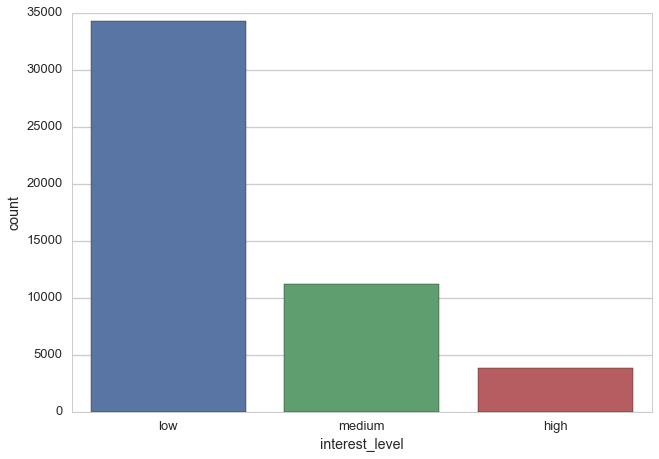

In [109]:
# the "low" interest category accounts for a majority of the class labels.
# therefore, it may be worth exploring the option of balancing class labels for prediction

sns.countplot(train_df.interest_level, order=['low', 'medium', 'high']);

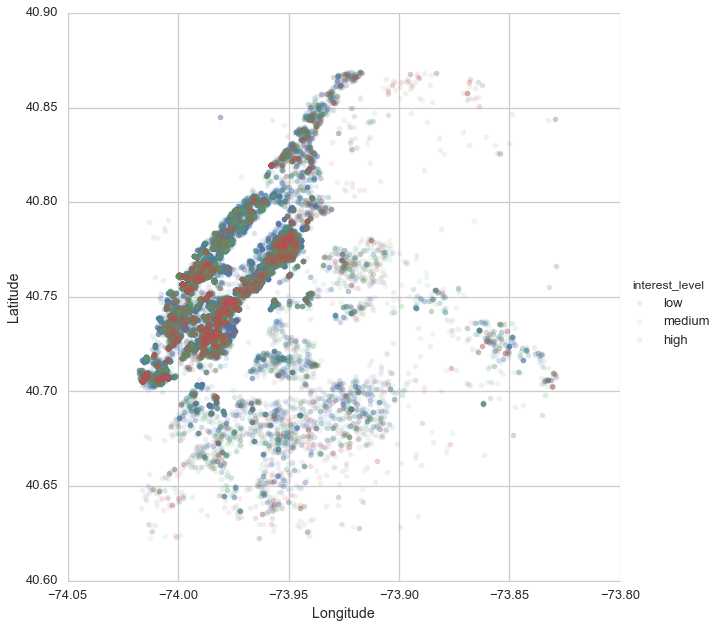

In [110]:
# plotting geo coordinates on latitude and longitude shows and outline of new york neighborhoods.
# deep red color highlights neighborhoods with highest interest level.

# dealing with zero and outlier values
train_df.latitude.nlargest(20)
train_df.latitude.nsmallest(20)
train_df.longitude.nlargest(20)
train_df.longitude.nsmallest(20)

sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.1,'s':30},
           data=train_df[(train_df.longitude>train_df.longitude.quantile(0.005))
                           &(train_df.longitude<train_df.longitude.quantile(0.995))
                           &(train_df.latitude>train_df.latitude.quantile(0.005))                           
                           &(train_df.latitude<train_df.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');

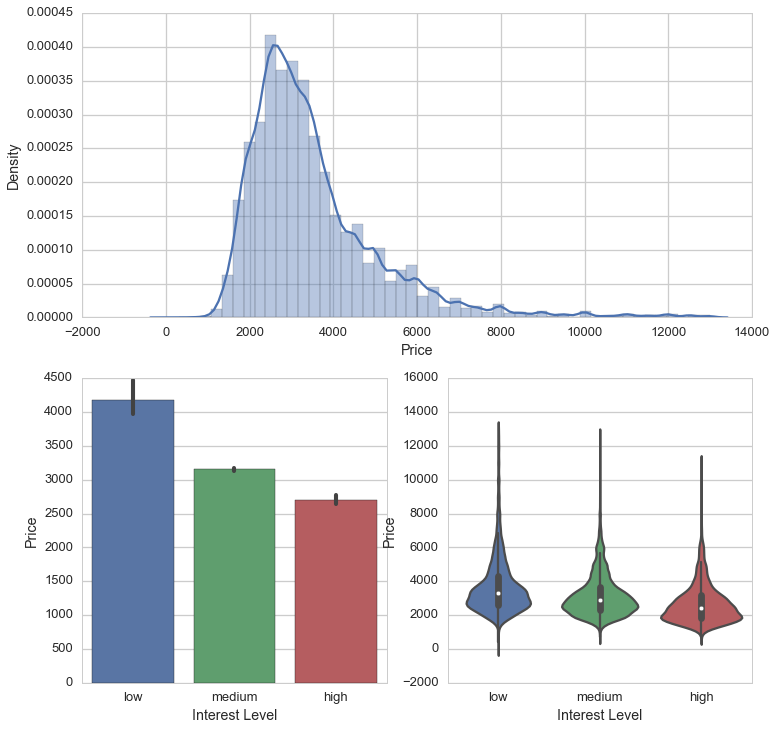

In [111]:
# Price exploration

fig = plt.figure(figsize=(12,12))

### Price distribution
# distplot plot shows that strongest density is for prices between $2000 to $4000,
# yet there is a substantial right long tail skew.
sns.distplot(train_df.price[train_df.price<=train_df.price.quantile(0.99)], ax=plt.subplot(211));
plt.xlabel('Price');
plt.ylabel('Density');

# Average Price per Interest Level
# prive vs interest bar graph shows that higher priced listings have lower interest levels
sns.barplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(223));
plt.xlabel('Interest Level');
plt.ylabel('Price');

# Violinplot of price for every Interest Level
# distribution of price varies by interest level, with high interest level being
# most dense at lower price points, and low interest level being most dense at slightly
# higher price points
sns.violinplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
               data=train_df[train_df.price<=train_df.price.quantile(0.99)],
               ax=plt.subplot(224));
plt.xlabel('Interest Level');
plt.ylabel('Price');

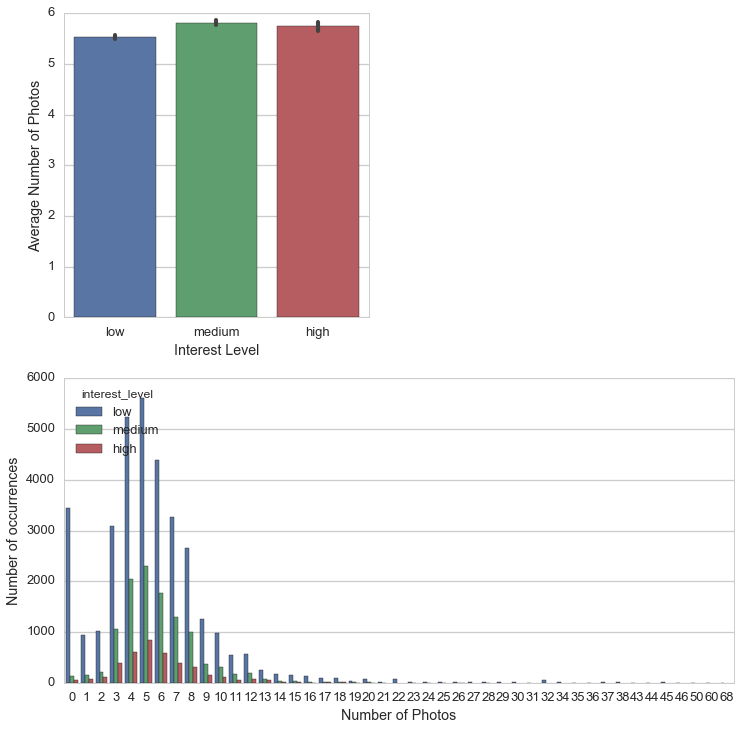

In [112]:
# Number of photos graphs

fig = plt.figure(figsize=(12,12))

### Average number of Photos per Interest Level
# bar plot shows not much of a difference in number of photos by interest level
sns.barplot(x="interest_level", y="photos_count", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(221));
plt.xlabel('Interest Level');
plt.ylabel('Average Number of Photos');

### Number of occurrences
# countplot shows long right tail
sns.countplot(x='photos_count', hue='interest_level', hue_order=['low', 'medium', 'high'],
              data=train_df, ax=plt.subplot(212));
plt.xlabel('Number of Photos');
plt.ylabel('Number of occurrences');

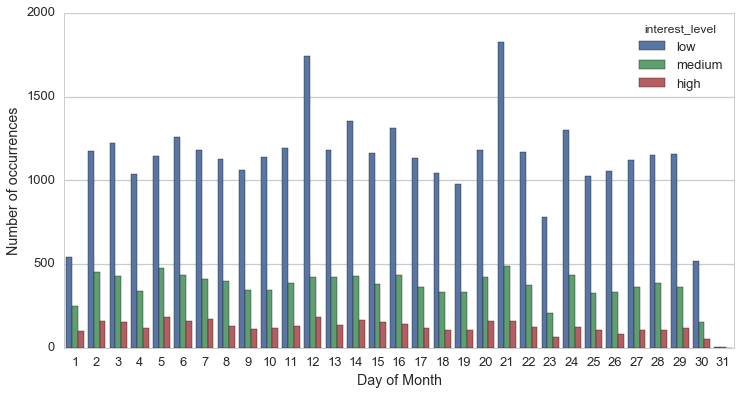

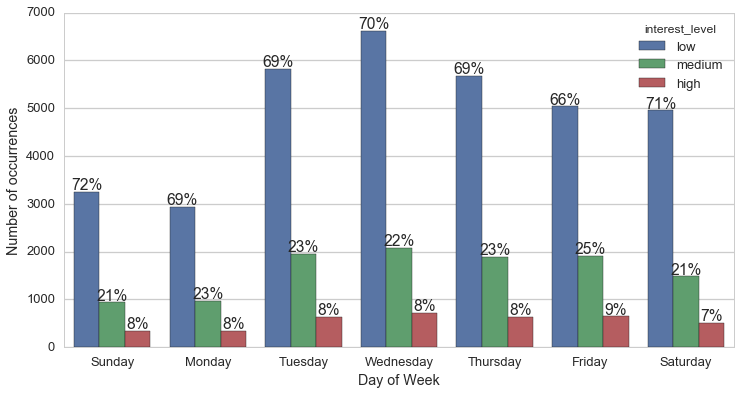

In [113]:
# interest by day of month
# there seems to be a cyclical pattern for interest by day of month,
# yet intuivively this is hard to interpret so let's look at day of week
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(x="day", hue="interest_level",
                   hue_order=['low', 'medium', 'high'], data=train_df);
plt.xlabel('Day of Month');
plt.ylabel('Number of occurrences');

# interest by day of week
# interest level seems to be highest for tuesday through saturday
fig = plt.figure(figsize=(12,6))
train_df['day_of_week'] = train_df.created.dt.weekday_name
ax = sns.countplot(x="day_of_week", hue="interest_level",
                   hue_order=['low', 'medium', 'high'], data=train_df,
                   order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);
plt.xlabel('Day of Week');
plt.ylabel('Number of occurrences');

### Adding percents over bars
height = [p.get_height() for p in ax.patches]
ncol = int(len(height)/3)
total = [height[i] + height[i + ncol] + height[i + 2*ncol] for i in range(ncol)] * 3
for i, p in enumerate(ax.patches):    
    ax.text(p.get_x()+p.get_width()/2,
            height[i] + 50,
            '{:1.0%}'.format(height[i]/total[i]),
            ha="center") 

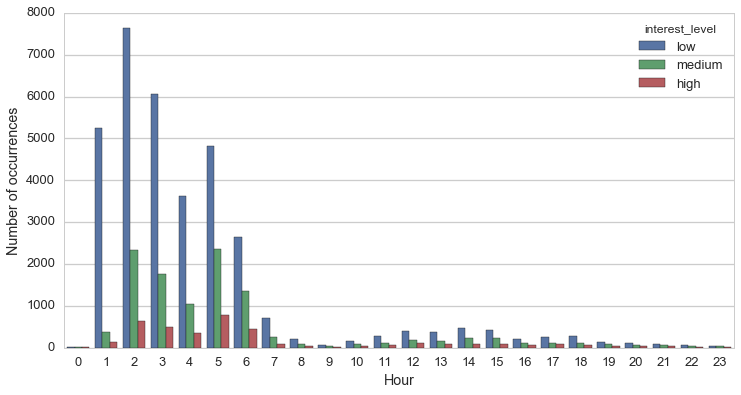

In [114]:
# interest by time of day
# not sure what to make of this; perhaps different time zone?

fig = plt.figure(figsize=(12,6))
sns.countplot(x="hour", hue="interest_level", hue_order=['low', 'medium', 'high'], data=train_df);
plt.xlabel('Hour');
plt.ylabel('Number of occurrences');

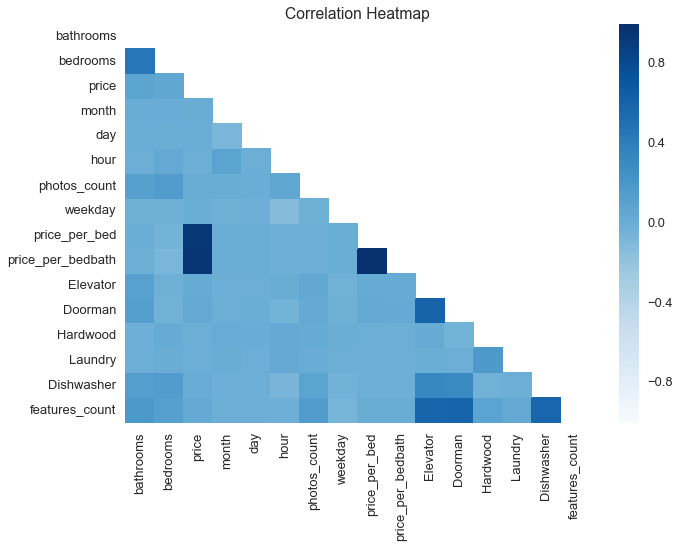

In [115]:
# correlation heatmap
# variables appear to be mostly independent of each other, with the exception of the variables that
# were created from other variables

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context('talk')

# set figure and axes
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# calculate correlation matix
corr = full_df.iloc[:,(1,2,13,16,17,18,19,20,21,22,23,24,25,26,27,28)].corr()
# mask the duplicate comparisons
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# create the correlation matrix heatmap using Seaborn
ax1 = sns.heatmap(corr, mask=mask, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='Blues')
ax1.set_title('Correlation Heatmap')

### Assessing feature importance using Random Forest

In [50]:
# import random forest algorithm
from sklearn.ensemble import RandomForestClassifier

# select variables; leaving out categorical data for now
X_train_rf_features = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_train_rf_features = y_train
X_test_rf_features = X_test[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]
feature_labels = full_df.columns[[1,2,8,10,13,16,17,18,19,20,21,22,23,24,25,26,27,28]]

# set features for RF
forest = RandomForestClassifier(n_estimators=250,
                               random_state=1,
                               n_jobs=-1)
# fit the model
forest.fit(X_train_rf_features,y_train_rf_features)

# obtain feature importances
feat_importance = forest.feature_importances_

# create indices
indices = np.argsort(feat_importance)[::-1]

# print variables and standardized importance score
for f in range(X_train_rf_features.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_labels[indices[f]], feat_importance[indices[f]]))

 1) longitude                      0.110802
 2) latitude                       0.108876
 3) price_per_bed                  0.106735
 4) price                          0.100851
 5) price_per_bedbath              0.097978
 6) day                            0.089712
 7) hour                           0.080536
 8) photos_count                   0.076805
 9) features_count                 0.074073
10) weekday                        0.057999
11) month                          0.033148
12) bedrooms                       0.016483
13) Dishwasher                     0.013511
14) Elevator                       0.012539
15) Doorman                        0.010169
16) bathrooms                      0.008841
17) Hardwood                       0.000748
18) Laundry                        0.000194


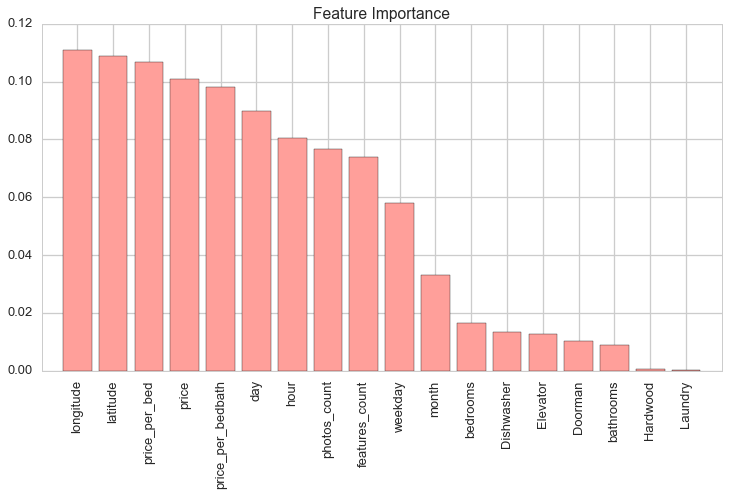

In [51]:
# this is a visual representation of the results from above

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context('talk')

plt.bar(range(X_train_rf_features.shape[1]), feat_importance[indices],
       color='r',
       align='center')
plt.xticks(range(X_train_rf_features.shape[1]), feature_labels[indices], 
           rotation=90)
plt.xlim([-1, X_train_rf_features.shape[1]])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Exploring dimensionality reduction using Principle Component Analysis

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)

In [66]:
# only using numeric and categorical data w/ dummy variables
X_train_for_pca = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]

# standardize the data
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_for_pca_std = stdsc.fit_transform(X_train_for_pca)

# fitting pca to the data
X_train_pca = pca.fit_transform(X_train_for_pca_std)

/Users/leeeyler/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


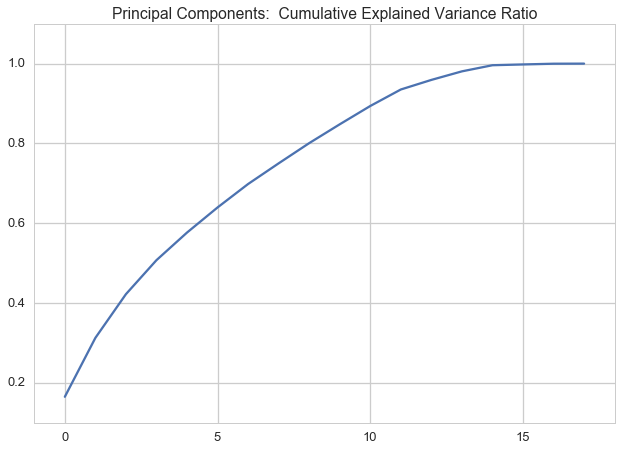

In [106]:
# obtain feature importances
pca_var_explained = pca.explained_variance_ratio_ 
feature_labels = full_df.columns[[1,2,8,10,13,16,17,18,19,20,21,22,23,24,25,26,27,28]]

# cumulative sum of explained ration
cumulative_var_explained = np.cumsum(pca_var_explained)

# cumulative distribution function for principle componets
# based on explained variance ratio
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context('talk')

plt.plot(range(X_train_for_pca.shape[1]), cumulative_var_explained)
plt.xlim([-1, X_train_for_pca.shape[1]])
plt.title('Principal Components:  Cumulative Explained Variance Ratio')

### Exploring feature extraction with Linear Discriminant Analysis

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='eigen',n_components=None)

In [81]:
# only using numeric and categorical data w/ dummy variables
X_train_for_lda = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_train_for_lda = y_train

# standardize the data
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_for_lda_std = stdsc.fit_transform(X_train_for_lda)

# fitting pca to the data
X_train_lda = lda.fit_transform(X_train_for_lda_std,y_train_for_lda)

/Users/leeeyler/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [82]:
lda.explained_variance_ratio_

array([ 0.9129556,  0.0870444])

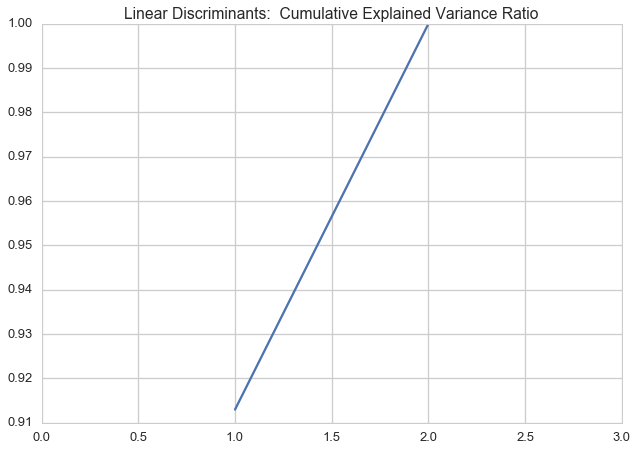

In [108]:
# obtain feature importances
lda_var_explained = lda.explained_variance_ratio_ 

# cumulative sum of explained ration
lda_cumulative_var_explained = np.cumsum(lda_var_explained)

# cumulative distribution function for principle componets
# based on explained variance ratio
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context('talk')

plt.plot(range(1,3), lda_cumulative_var_explained)
plt.xlim(0,3)
plt.title('Linear Discriminants:  Cumulative Explained Variance Ratio')

### Random Forest Classifier

##### What is a Random Forest Classifier?

1.  classification model that is built on an ensemble of decision trees
2.  combines multiple weak learners to build a strong learner
3.  draw a random bootstrap sample of size n from training data with replacement
4.  randomly select d features without replacement
5.  perform best possible split at the nodes according to the objective function, maximizing information gain
6.  repeat k number of times
7.  aggregate predictions and assign class lable based on majority vote
8.  information gain can be represented as:

    IG (parent node, feature) = Impurity(parent node) - (# samples left / # of samples parent) * Impurity (left child) - (# samples right / # of samples parent) * Impurity (right child)

9.  the two most common definitions of impurity are:

    Entropy
    Entropy Impurity (node t) = -sum( proportion of samples in class i at node t * log2 * proportion of samples in class i at node t)

    Gini
    Gini Impurity (node t) = sum( proportion of samples in class i at node t * (1 - proportion of samples in class i at node t))

In [52]:
# import random forest classifier and cross val score from scikit-learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [53]:
# initiate random forest
forest = RandomForestClassifier(criterion='gini', n_estimators= 250, max_features='auto', random_state=1,n_jobs=-1)

In [54]:
# no grid search; only cross validation
rf_scores = cross_val_score(forest, X_train_rf_features, y_train_rf_features, scoring='accuracy', cv=10)
rf_scores.mean() - rf_scores.std(), rf_scores.mean(), rf_scores.mean() + rf_scores.std()

(0.72557776798683371, 0.73174339097955354, 0.73790901397227338)

### Random Forest Classifier ROC Curve

In [55]:
# subset data for ROC plot purposes
X_rf_roc = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]] #data only; no labels
y_rf_roc = y_train # no data; labels only

In [57]:
# binarize labels
from sklearn.preprocessing import label_binarize
y_rf_roc = label_binarize(y_rf_roc, classes=[0, 1, 2])
n_classes = y_rf_roc.shape[1]

In [58]:
# split training and test sets
from sklearn.model_selection import train_test_split
X_train_rf_roc, X_test_rf_roc, y_train_rf_roc, y_test_rf_roc = train_test_split(X_rf_roc, y_rf_roc, test_size=.7, random_state=1)

In [59]:
# predict classes
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(criterion='entropy', n_estimators=600, max_features=6,
                                 random_state=1,n_jobs=-1))
y_score = classifier.fit(X_train_rf_roc, y_train_rf_roc).predict(X_test_rf_roc)

In [116]:
# ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_rf_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [117]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_rf_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

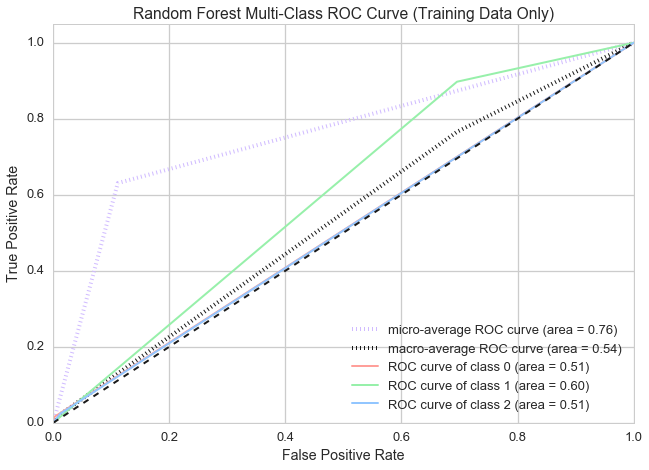

In [119]:
from scipy import interp

# aggregate false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average, and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='m', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='k', linestyle=':', linewidth=4)

colors = ['r', 'g', 'b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Multi-Class ROC Curve (Training Data Only)')
plt.legend(loc="lower right")
plt.show()

In [67]:
train_df.interest_level.value_counts()[1]

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [121]:
train_df.interest_level.value_counts()[0] / len(train_df.interest_level)

0.69468309288377372

In [122]:
train_df.interest_level.value_counts()[1] / len(train_df.interest_level)

0.22752877289674178

In [123]:
train_df.interest_level.value_counts()[2] / len(train_df.interest_level)

0.077788134219484523

In [152]:
train_df.interest_level.value_counts()[0] / train_df.interest_level.value_counts()[2]

8.9304506381870272

In [155]:
train_df.interest_level.value_counts()[1] / train_df.interest_level.value_counts()[2]

2.9249804636624122

### KNN Classifier w/ All Features

In [ ]:
# scale features for KNN
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# separate training data, training labels, and testing data
X_train_knn_features = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_train_knn_features = y_train
X_test_knn_features = X_test[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]]

# standardize training and testing data
X_train_knn_features_std = stdsc.fit_transform(X_train_knn_features)
X_test_knn_features_std = stdsc.fit_transform(X_test_knn_features)

In [ ]:
# initialize knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='minkowski', p=1, n_neighbors=4, n_jobs=-1)

In [ ]:
# no grid search; only cross validation
knn_scores = cross_val_score(knn, X_train_knn_features_std, y_train_knn_features, scoring='accuracy', cv=10)
knn_scores.mean() - knn_scores.std(), knn_scores.mean(), knn_scores.mean() + knn_scores.std()

### KNN Classifier w/ Using Features from Random Forest Feature Selection

In [ ]:
# scale features for KNN
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# separate training data, training labels, and testing data
X_train_knn_features_select = X_train[:,[7,9,12,16,17,18,20,21,27]]
y_train_knn_features_select = y_train
X_test_knn_features_select = X_test[:,[7,9,12,16,17,18,20,21,27]]

# standardize training and testing data
X_train_knn_features_select_std = stdsc.fit_transform(X_train_knn_features_select)
X_test_knn_features_select_std = stdsc.fit_transform(X_test_knn_features_select)

In [128]:
# initialize knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='minkowski', p=1, n_neighbors=4, n_jobs=-1)

In [ ]:
# no grid search; only cross validation
knn_fs_scores = cross_val_score(knn, X_train_knn_features_select_std, y_train_knn_features_select, scoring='accuracy', cv=10)
knn_fs_scores.mean() - knn_fs_scores.std(), knn_fs_scores.mean(), knn_fs_scores.mean() + knn_fs_scores.std()

### KNN Classifier ROC Curve

In [129]:
# subset data for ROC plot purposes
X_knn_roc = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]] #data only; no labels
y_knn_roc = y_train # no data; labels only

In [130]:
# binarize labels
from sklearn.preprocessing import label_binarize
y_knn_roc = label_binarize(y_knn_roc, classes=[0, 1, 2])
n_classes = y_knn_roc.shape[1]

In [131]:
# split training and test sets
from sklearn.model_selection import train_test_split
X_train_knn_roc, X_test_knn_roc, y_train_knn_roc, y_test_knn_roc = train_test_split(X_knn_roc, y_knn_roc, test_size=.7, random_state=1)

In [132]:
# predict classes
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=8, p=1, metric='minkowski',n_jobs=-1))
y_score = classifier.fit(X_train_knn_roc, y_train_knn_roc).predict(X_test_knn_roc)

In [133]:
# ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_knn_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [134]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_knn_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

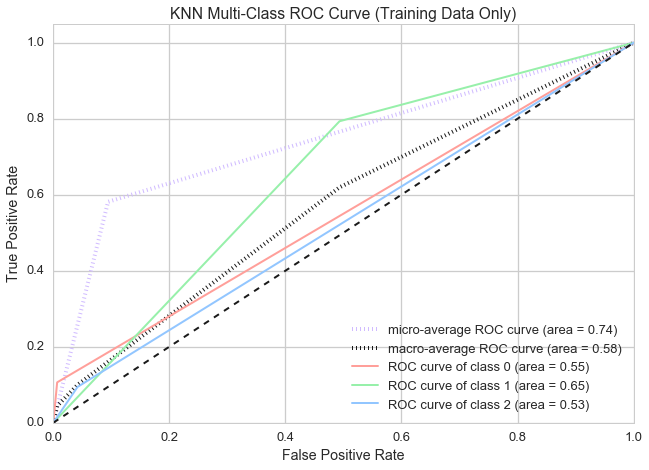

In [135]:
from scipy import interp

# aggregate false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average, and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='m', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='k', linestyle=':', linewidth=4)

colors = ['r', 'g', 'b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Multi-Class ROC Curve (Training Data Only)')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression Classifier

##### What is Logistic Regression?

1.  classification model that can perform well on linearly separable classes
2.  can be used for both binary and multi-class classification (via One v Rest)
3.  logistic regression is grounded in probability, speficially looking at the odds in favor or a particular event
4.  odds ratio = (probability of event we want to predict / (1 - probability of event we want to predict))
5.  logit function, ie logarithm of odds ratio = 
        log(probability of event we want to predict / (1 - probability of event we want to predict))
6.  logit function takes inputs between 0 and 1 and transforms the inputs into real numbers, which can be expressed as a linear relationship
7.  logit(probability( event we want to predict given that the observation has feature x)) = w0x0 + w1x1 + ... + wnxn
8.  we want the actual probability, so we use the logistic function (sometimes called sigmoid) which is the inverse of logit function
        1 / (1 + log^-(w0x0 + w1x1 + ... + wnxn))
10.  result is a probability that an observation belongs to a particular class
11.  we can also convert the probabilities into binary outcomes via a quantizer (ex. if probability > 50%, then label as class 1)
12.  optimizing via gradient ascent:  the weights for logistic regression are being optimized by maximizing the log-likelihood function
12.  optimizing via gradient descent:  loglikelihood function is rewritten as a cost function that can be minimized in order to optimize the weights for logstic regression
13.  with either optimization method, we penalize wrong predictions with an increasingly larger cost

In [64]:
# scale features for logistic regression
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# separate training data, training labels, and testing data
X_train_lr_features = X_train[:,[0,1,7,9,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_train_lr_features = y_train
X_test_lr_features = X_test[:,[0,1,7,9,15,16,17,18,19,20,21,22,23,24,25,26,27]]

# standardize training and testing data
X_train_lr_features_std = stdsc.fit_transform(X_train_lr_features)
X_test_lr_features_std = stdsc.fit_transform(X_test_lr_features)

/Users/leeeyler/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [65]:
# initiate logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', C=10, random_state=1, n_jobs=-1)

In [66]:
# no grid search; only cross validation
lr_scores = cross_val_score(lr, X_train_lr_features_std, y_train_lr_features, scoring='accuracy', cv=10)
lr_scores.mean() - lr_scores.std(), lr_scores.mean(), lr_scores.mean() + lr_scores.std()

(0.69148045166187666, 0.69555453954215207, 0.69962862742242748)

*** Let's check out the coefficients for the Logistic Regression Model ***

In [88]:
# coefficients for scaled units
# class 0 vs class 1 and 2

# obtain features labels
lr_feature_labels = full_df.columns[[1,2,8,10,16,17,18,19,20,21,22,23,24,25,26,27,28]]
#X_train_lr_features = X_train[:,[0,1,7,9,15,16,17,18,19,20,21,22,23,24,25,26,27]]

# obtain feature importances
lr_feat_importance = lr.coef_[0]

# create indices
lr_indices = np.argsort(lr_feat_importance)[::-1]

# print variables and standardized importance score
for f in range(X_train_lr_features_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, lr_feature_labels[lr_indices[f]], lr_feat_importance[lr_indices[f]]))

 1) hour                           0.321119
 2) features_count                 0.186402
 3) Dishwasher                     0.166972
 4) photos_count                   0.062651
 5) weekday                        0.061861
 6) Elevator                       0.052176
 7) Laundry                        0.013491
 8) Hardwood                       -0.021233
 9) bathrooms                      -0.021678
10) month                          -0.031334
11) Doorman                        -0.054542
12) latitude                       -0.091034
13) day                            -0.109799
14) longitude                      -0.117213
15) bedrooms                       -0.895487
16) price_per_bedbath              -5.795214
17) price_per_bed                  -17.343286


In [89]:
# coefficients for scaled units
# class 1 vs class 0 and 2

# obtain features labels
lr_feature_labels = full_df.columns[[1,2,8,10,16,17,18,19,20,21,22,23,24,25,26,27,28]]

# obtain feature importances
lr_feat_importance = lr.coef_[1]

# create indices
lr_indices = np.argsort(lr_feat_importance)[::-1]

# print variables and standardized importance score
for f in range(X_train_lr_features_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, lr_feature_labels[lr_indices[f]], lr_feat_importance[lr_indices[f]]))

 1) price_per_bed                  12.157538
 2) price_per_bedbath              5.515752
 3) longitude                      0.706943
 4) latitude                       0.670105
 5) bedrooms                       0.668983
 6) day                            0.064429
 7) bathrooms                      0.064183
 8) month                          0.042861
 9) Doorman                        0.031644
10) Laundry                        0.000586
11) Hardwood                       -0.024765
12) weekday                        -0.046270
13) Elevator                       -0.068508
14) photos_count                   -0.095732
15) features_count                 -0.201367
16) Dishwasher                     -0.287685
17) hour                           -0.319753


In [90]:
# coefficients for scaled units
# class 2 vs class 0 and 1

# obtain features labels
lr_feature_labels = full_df.columns[[1,2,8,10,16,17,18,19,20,21,22,23,24,25,26,27,28]]

# obtain feature importances
lr_feat_importance = v.coef_[2]

# create indices
lr_indices = np.argsort(lr_feat_importance)[::-1]

# print variables and standardized importance score
for f in range(X_train_lr_features_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, lr_feature_labels[lr_indices[f]], lr_feat_importance[lr_indices[f]]))

 1) Dishwasher                     0.279499
 2) hour                           0.205550
 3) features_count                 0.152026
 4) photos_count                   0.075713
 5) Elevator                       0.053192
 6) weekday                        0.024272
 7) Hardwood                       0.019482
 8) Doorman                        -0.002088
 9) Laundry                        -0.016349
10) day                            -0.030055
11) month                          -0.034820
12) bathrooms                      -0.080302
13) latitude                       -0.260660
14) longitude                      -0.280464
15) bedrooms                       -0.406338
16) price_per_bedbath              -3.670783
17) price_per_bed                  -8.135756


### Logistic Regression Classifier w/ Using Features from Random Forest Feature Selection

In [69]:
# scale features for logistic regression
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# separate training data, training labels, and testing data
X_train_lr_features_select = X_train[:,[7,9,16,17,18,20,21,27]]
y_train_lr_features_select = y_train
X_test_lr_features_select = X_test[:,[7,9,16,17,18,20,21,27]]

# standardize training and testing data
X_train_lr_features_select_std = stdsc.fit_transform(X_train_lr_features_select)
X_test_lr_features_select_std = stdsc.fit_transform(X_test_lr_features_select)

/Users/leeeyler/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [70]:
# initiate logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', C=10, random_state=1, n_jobs=-1)

In [71]:
# no grid search; only cross validation
lr_fs_scores = cross_val_score(lr, X_train_lr_features_select_std, y_train_lr_features_select, scoring='accuracy', cv=10)
lr_fs_scores.mean() - lr_fs_scores.std(), lr_fs_scores.mean(), lr_fs_scores.mean() + lr_fs_scores.std()

(0.68877017582389244, 0.69138030682828888, 0.69399043783268533)

### Logistic Regression Classifier ROC Curve

In [72]:
# subset data for ROC plot purposes
X_lr_roc = X_train[:,[0,1,7,9,12,15,16,17,18,19,20,21,22,23,24,25,26,27]] #data only; no labels
y_lr_roc = y_train # no data; labels only

In [73]:
# binarize labels
from sklearn.preprocessing import label_binarize
y_lr_roc = label_binarize(y_lr_roc, classes=[0, 1, 2])
n_classes = y_lr_roc.shape[1]

In [74]:
# split training and test sets
from sklearn.model_selection import train_test_split
X_train_lr_roc, X_test_lr_roc, y_train_lr_roc, y_test_lr_roc = train_test_split(X_lr_roc, y_lr_roc, test_size=.7, random_state=1)

In [75]:
# predict classes
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', random_state=1, C=10, n_jobs=-1))
y_score = classifier.fit(X_train_lr_roc, y_train_lr_roc).predict(X_test_lr_roc)

In [76]:
# ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_lr_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [77]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_lr_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

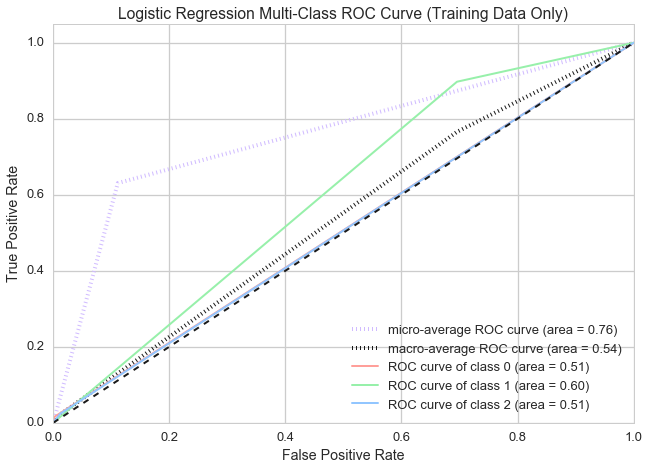

In [112]:
from scipy import interp

# aggregate false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average, and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='m', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='k', linestyle=':', linewidth=4)

colors = ['r', 'g', 'b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Multi-Class ROC Curve (Training Data Only)')
plt.legend(loc="lower right")
plt.show()

## Model Tuning

In [91]:
# based on the accuracy and ROC AUC scores, it seems like the random forest classifier
# is better than the KNN and logistic regression models at correctly classifying the interest
# level of a new apartment listing.  therefore, let's focus on tuning the random forest
# model in order to maximize classification performance.

# initiate random forest for grid search and cross validation
forest = RandomForestClassifier(random_state=1,n_jobs=-1)

# create parameter grid for grid search
crit_param = ['gini','entropy']
tree_param = [300,600]
max_feature_param = [3,6]
gs_param_grid = [{'criterion': crit_param,
               'n_estimators': tree_param,
               'max_features': max_feature_param
              }]

In [92]:
# create grid search object
rf_gridsearch = GridSearchCV(estimator=forest, param_grid=gs_param_grid, scoring='accuracy',
                            cv=5, n_jobs=-1)

In [93]:
# fit grid search model
rf = rf_gridsearch.fit(X_train_rf_features, y_train_rf_features)

In [95]:
rf.best_score_

0.73081131463770466

In [97]:
rf.best_params_

{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 600}

In [98]:
# create and fit the best rf model
rf_best = RandomForestClassifier(criterion='entropy', n_estimators=600, max_features=6,
                                 random_state=1,n_jobs=-1)

rf_best.fit(X_train_rf_features, y_train_rf_features)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

## Random Forest Classifier Submission for Kaggle

In [109]:
# kaggle submission must have listing id, high interest probability, medium interest probability, 
# and low interest probability
rf_submission = pd.DataFrame(test_df.iloc[:,9].copy())
rf_submission['high'] = rf_best.predict_proba(X_test_rf_features)[:,2]
rf_submission['medium'] = rf_best.predict_proba(X_test_rf_features)[:,1]
rf_submission['low'] = rf_best.predict_proba(X_test_rf_features)[:,0]
rf_submission.head()

,listing_id,high,medium,low
49352,7142618,0.39,0.55,0.06
49353,7210040,0.43,0.21,0.36
49354,7103890,0.09,0.90,0.01
49355,7143442,0.34,0.59,0.07
49356,6860601,0.17,0.82,0.01


In [110]:
# write submission to csv file
rf_submission.to_csv('rf_submission.csv',index=False)